##Классификация статей РИА-Новости по рубрикам
Емельянов Виталий, ФИВТ

###1. Извлечение данных
В качестве источника обучающей выборки используем сайт РИА-Новости

In [118]:
import newspaper

rianews = newspaper.build("http://ria.ru/", memoize_articles=False, language='ru')
print rianews.size()

1105


CRITICAL:newspaper.network:[REQUEST FAILED] (<requests.packages.urllib3.connectionpool.HTTPConnectionPool object at 0xa21ad34c>, 'Connection to ria.ru timed out. (connect timeout=7)')


Посмотрим, как библиотека newspaper справляется с парсингом статей

In [92]:
first_article = rianews.articles[5]
first_article.download()
first_article.parse()
print first_article.url
print
print first_article.text[0:300] + '...'

http://ria.ru/world/20151130/1332685879.html

БРЮССЕЛЬ, 30 ноя — РИА Новости, Владимир Добровольский. Турция не намерена извиняться перед Россией за то, что сбила российский Су-24, заявил премьер-министр страны Ахмет Давутоглу.

"Защита нашего воздушного пространства, сухопутной границы — это не просто наше право, но и наш долг. Никто не будет ...


Выкачаем первые 990 статей, извлечем из каждой текст и сохраним в папке ria/ в отдельный файл %N.txt

In [93]:
counter = 0
for i in xrange(990):
    rianews.articles[i].download()
    rianews.articles[i].parse()
    filename = "ria/" + str(counter) + ".txt"
    counter += 1
    with open(filename, 'w+') as f:
        f.write(rianews.articles[i].url)
        f.write('\n')
        f.write(rianews.articles[i].text.encode('utf-8'))

###2. Построение обучающей выборки

Посмотрим на структуру url сайта ria.ru

In [94]:
import os
import numpy as np


with open('ria/1.txt', 'r') as f:
    data_in = f.read()
lines = data_in.split('\n')
url = lines[0]  
print url

with open('ria/132.txt', 'r') as f:
    data_in = f.read()
lines = data_in.split('\n')
url = lines[0]  
print url

with open('ria/493.txt', 'r') as f:
    data_in = f.read()
lines = data_in.split('\n')
url = lines[0]  
print url

http://ria.ru/culture/20151115/1101521140.html
http://ria.ru/tv_sport/20151113/1320087183.html
http://ria.ru/economy/20151115/1321054488.html#comments


Теперь можно предположить, что рубрика статьи - это то, что идет после "http://ria.ru/" до  первого "/".
Извлечем из выкачанного множества статей, рубрику и текст статьи, исходя из нашего предположения

In [95]:
import os
import urlparse


file_list = os.listdir('./ria')

news_list = []
for filename in file_list:
    with open('ria/' + filename, 'r') as f:
        data_in = f.read()
        lines = data_in.split('\n')
        url = lines[0]
        topic = urlparse.urlsplit(url).path.split('/')[1]
        text = '\n'.join(lines[1:])
        news_list.append({'topic': topic, 'text': text.decode('utf-8')})
print "Number of articles:", len(news_list)

Number of articles: 498


Заведем set из рубрик и посмотрим на них

In [96]:
topics = dict()
for i in xrange(len(news_list)):
    if news_list[i]['topic'] not in topics:
       topics[news_list[i]['topic']] = 1
    else:
        topics[news_list[i]['topic']] += 1
  
print "Number of topics:", len(topics)
print
print "Topics:"

for item in sorted(topics.items()):
    print item[0], item[1]

Number of topics: 45

Topics:
Tech_news 1
analytics 7
announce 74
arab_sy 1
asia 3
culture 1
docs 1
economy 82
games 2
gl 3
history_video 3
incidents 7
infografika 1
moscow 6
multimedia 2
opinions 1
photolents 3
politics 74
r_chronicles 1
religion 1
science 2
sochi2014_torchrelay 1
society 6
syria 1
syria_is 1
syria_mm 4
tags 3
titanic_interactive 1
tournament 17
trend 2
tv_culture 1
tv_defense_safety 3
tv_eco 3
tv_economy 1
tv_incidents 9
tv_politics 20
tv_science 2
tv_society 12
tv_sport 5
valdaiclub_anniversary_announcement 1
victorina 4
video 8
videoclub 3
vote 3
world 111


Видим, что наше предположение оказалось верным и у нас 45 рубрик.

Суффикс tv у рубрики говорит о том, что в статье находится видеоролик как это можно видеть на примере http://ria.ru/tv_culture/20151111/1318661856.html<br/>
Будем считать, что tv_rubric то же, что и rubric. 

In [97]:
for news in news_list:
    if news['topic'] == "tv_culture":
        news['topic'] = "culture"
    if news['topic'] == "tv_economy":
        news['topic'] = "economy"
    if news['topic'] == "tv_incidents":
        news['topic'] = "incidents"
    if news['topic'] == "tv_politics":
        news['topic'] = "politics"
    if news['topic'] == "tv_society":
        news['topic'] = "society"
    if news['topic'] == "tv_sport":
        news['topic'] = "sport"
    if news['topic'] == "tv_science":
        news['topic'] = "science"
    if news['topic'] == "tv_defense_safety":
        news['topic'] = "defense_safety"
    if news['topic'] == "tv_eco":
        news['topic'] = "eco"

Также мы видим что есть 3 рубрики по Сирии: syria, syria_is, syria_mm.<br/>
Видимо, syria_is - все что касается ISIS, а syria_mm - military map. Объединим эти три рубрики в одну.

In [98]:
for news in news_list:
    if news['topic'] == "syria_is":
        news['topic'] = "syria"
    if news['topic'] == "syria_mm":
        news['topic'] = "syria"
        
topics = dict()
for i in xrange(len(news_list)):
    if news_list[i]['topic'] not in topics:
       topics[news_list[i]['topic']] = 1
    else:
        topics[news_list[i]['topic']] += 1
for item in sorted(topics.items()):
    print item[0], item[1]

Tech_news 1
analytics 7
announce 74
arab_sy 1
asia 3
culture 2
defense_safety 3
docs 1
eco 3
economy 83
games 2
gl 3
history_video 3
incidents 16
infografika 1
moscow 6
multimedia 2
opinions 1
photolents 3
politics 94
r_chronicles 1
religion 1
science 4
sochi2014_torchrelay 1
society 18
sport 5
syria 6
tags 3
titanic_interactive 1
tournament 17
trend 2
valdaiclub_anniversary_announcement 1
victorina 4
video 8
videoclub 3
vote 3
world 111


Исключим статьи и рубрики, где меньше 7 статей в рубрике.

In [99]:
min_size = 4

updated_news_list = []
updated_topics = dict()
for topic in topics:
    if topics[topic] >= min_size:
        updated_topics[topic] = topics[topic]
        for article in news_list:
            if article['topic'] == topic:
                updated_news_list.append({'topic': article['topic'], 'text': article['text']})
news_list = updated_news_list
topics = updated_topics

for item in sorted(topics.items()):
    print item[0], item[1]

analytics 7
announce 74
economy 83
incidents 16
moscow 6
politics 94
science 4
society 18
sport 5
syria 6
tournament 17
victorina 4
video 8
world 111


In [100]:
print "Number of articles: ", len(news_list)

Number of articles:  453


Теперь у нас есть размеченная выборка размером в 428 статей.

###3. Построение признаков и baseline

Для построения baseline построим bag-of-words.

In [101]:
from sklearn.feature_extraction.text import CountVectorizer

texts = []
answers = []
for article in news_list:
    answers.append(article['topic'])
    texts.append(article['text'])
 
vectorizer = CountVectorizer()
X  = vectorizer.fit_transform(texts, answers)

"Оценка" качества

In [102]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split

classifiers = {
        'naive_bayes': MultinomialNB(),
        'random_forest': RandomForestClassifier(n_estimators = 40),
        'logistic_regression': LogisticRegression(),
        'svc': SVC(kernel='linear')
}
def getCVScores(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    for classifier in classifiers:
        classifiers[classifier].fit(X_train, y_train)
        print classifier
        print classifiers[classifier].score(X_test, y_test)
        print

Применим какие-нибудь алгоритмы классификации к нашему bag-of-words, посмотрим на качество и выберем в качестве baseline алгоритм с лучшим качеством.

In [103]:
getCVScores(X, answers)

logistic_regression
0.741758241758

naive_bayes
0.686813186813

random_forest
0.664835164835

svc
0.692307692308



Логистическая регрессия показала самое лучшее качество. Посмотрим как она классифицирует следующую статью:

In [104]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X, answers)
ans = logistic_classifier.predict(vectorizer.transform(["Выход фильма «Сделано во Франции» о подготовке теракта в Париже отложили на неопределенное время, сообщает The Time. Такое решение кинопрокатчики приняли на фоне террористических атак, которые произошли во французской столице в ночь на 14 ноября."]))
print "Answer: ", ans[0]

Answer:  politics


Кажется, что это больше походит на анонс нежели на статью о политике. Хотя кто-то, думаю, может отнести ее и к политической новости.

###4. Более хитрые признаки 

####Отсев стоп-слов и стемминг 

In [105]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer

tokenizer = RegexpTokenizer(r'\w+')
stemmer = RussianStemmer()

stemmed_texts = []
for article in texts:
    tokenized_article  = tokenizer.tokenize(article)
    stemmed_article = []
    for word in tokenized_article: 
        if word not in stopwords.words('russian'):
            stemmed_article.append(stemmer.stem(word))
    stemmed_texts.append(' '.join(stemmed_article))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:13: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


####TF–IDF term weighting

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
Xtfidf = vectorizer.fit_transform(stemmed_texts, answers)

Xtfidf.shape

(453, 11274)

####N-граммы

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 4)) 
Xngram = ngram_vectorizer.fit_transform(texts, answers) 

Xngram.shape

(453, 52807)

###5. Настройка гиперпараметров


Функция, визуализирующая "кривую обучения"

In [109]:
from matplotlib import pyplot as plt
from sklearn.learning_curve import learning_curve
%matplotlib inline

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Функции, реализующие жадный подбор гиперпараметров, строящие кривую обучения, показывающие score на тестовой выборке

In [110]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
import numpy as np


def svc_report(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.3, random_state=0)

    gammas = np.logspace(-6, -1, 10)
    svc = GridSearchCV(estimator=SVC(kernel='linear'), cv=cv, param_grid=dict(gamma=gammas))
    svc.fit(X_train, y_train)
    
    title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %svc.best_estimator_.gamma
    estimator = SVC(kernel='linear', gamma=svc.best_estimator_.gamma)
    plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
    plt.show()
    
    print "Score on test set: ", svc.score(X_test, y_test)


def logistic_regression_report(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.3, random_state=0)

    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    logreg = GridSearchCV(estimator=LogisticRegression(penalty='l1'), cv=cv, param_grid=param_grid)
    logreg.fit(X_train, y_train)

    title = 'Learning Curves (Logistic Regression, $C=%.6f$)' %logreg.best_estimator_.C
    estimator = LogisticRegression(C=logreg.best_estimator_.C)
    plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
    plt.show()
    
    print "Score on test set: ", logreg.score(X_test, y_test)
    
def multinomial_nb_report(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.3, random_state=0)
    
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1] }
    nb = GridSearchCV(estimator=MultinomialNB(), cv=cv, param_grid=param_grid)
    nb.fit(X_train, y_train)

    title = 'Learning Curves (Multinomial Naive Bayes, $alpha=%.6f$)' %nb.best_estimator_.alpha
    estimator = MultinomialNB(alpha=nb.best_estimator_.alpha)
    plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
    plt.show()
    
    print "Score on test set: ", nb.score(X_test, y_test)


####5.1 Настройка гиперпараметров на признаках, полученных после стемминга и TfidfVectorizer

####SVC

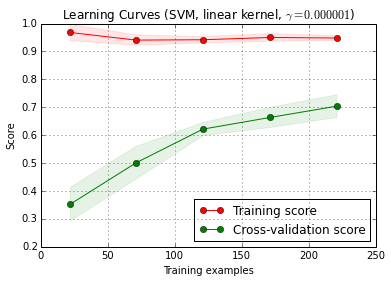

Score on test set:  0.75


In [111]:
svc_report(Xtfidf, answers)

####Логистическая регрессия


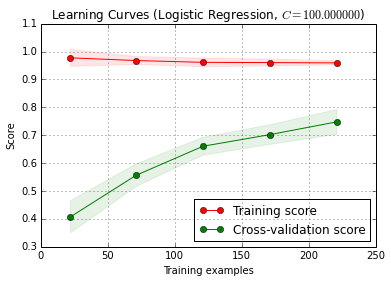

Score on test set:  0.779411764706


In [112]:
logistic_regression_report(Xtfidf, answers)

####Multinomial Naive Bayes

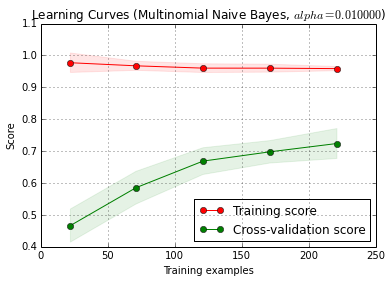

Score on test set:  0.779411764706


In [113]:
multinomial_nb_report(Xtfidf, answers)

####5.2 Настройка гиперпараметров на признаках, полученных после n-gram СountVectorizer

####SVC

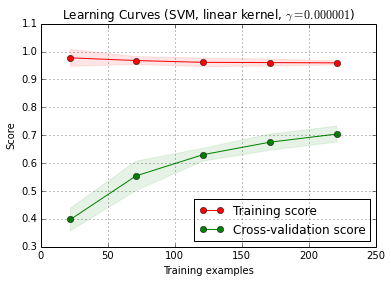

Score on test set:  0.75


In [114]:
svc_report(Xngram, answers)

####Логистическая регрессия

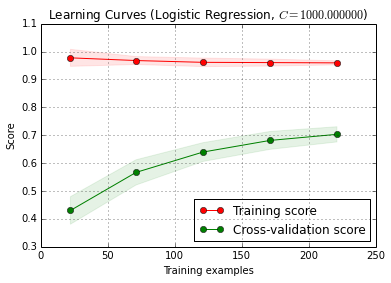

Score on test set:  0.801470588235


In [115]:
logistic_regression_report(Xngram, answers)

####Multinomial Naive Bayes

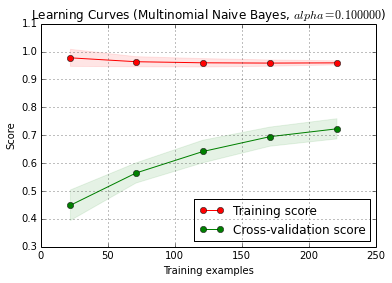

Score on test set:  0.772058823529


In [116]:
multinomial_nb_report(Xngram, answers)

Лучшее качество на тестовой выборке показала логистическая регрессия с параметром $C = 1000$ на 3-,4-граммах